In [17]:
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
#loading in county and census data and sorting for NC
county_data = pd.read_csv("us-counties-2021.csv")

# Prepping census data to be merged
white = pd.read_excel("census data.xlsx")
white2 = white[['county', 'pct_white']]

del white

white2['pct_white'] = 1 - white2['pct_white']
white2 = white2.rename(columns = {'pct_white': 'Minority_pct'})
white2['Minority_pct'] = round(white2['Minority_pct'], 4)


census = pd.read_csv("County_totals2022.csv")
census = census.drop(census.columns[[1, 2, 4]], axis = 1)
census.columns.values[1] = 'Population'
census.columns.values[0] = 'county'
census = census.drop(census.index[-1])

#Population Density Data

data = {
    'county': [
        'Alamance', 'Alexander', 'Alleghany', 'Anson', 'Ashe', 'Avery', 'Beaufort', 'Bertie', 'Bladen',
        'Brunswick', 'Buncombe', 'Burke', 'Cabarrus', 'Caldwell', 'Camden', 'Carteret', 'Caswell', 'Catawba',
        'Chatham', 'Cherokee', 'Chowan', 'Clay', 'Cleveland', 'Columbus', 'Craven', 'Cumberland', 'Currituck',
        'Dare', 'Davidson', 'Davie', 'Duplin', 'Durham', 'Edgecombe', 'Forsyth', 'Franklin', 'Gaston', 'Gates',
        'Graham', 'Granville', 'Greene', 'Guilford', 'Halifax', 'Harnett', 'Haywood', 'Henderson', 'Hertford',
        'Hoke', 'Hyde', 'Iredell', 'Jackson', 'Johnston', 'Jones', 'Lee', 'Lenoir', 'Lincoln', 'Macon', 'Madison',
        'Martin', 'McDowell', 'Mecklenburg', 'Mitchell', 'Montgomery', 'Moore', 'Nash', 'New Hanover', 'Northampton', 'Onslow',
        'Orange', 'Pamlico', 'Pasquotank', 'Pender', 'Perquimans', 'Person', 'Pitt', 'Polk', 'Randolph', 'Richmond',
        'Robeson', 'Rockingham', 'Rowan', 'Rutherford', 'Sampson', 'Scotland', 'Stanly', 'Stokes', 'Surry', 'Swain',
        'Transylvania', 'Tyrrell', 'Union', 'Vance', 'Wake', 'Warren', 'Washington', 'Watauga', 'Wayne', 'Wilkes',
        'Wilson', 'Yadkin', 'Yancey'
    ],
    'population_density_per_sq_mile': [
        404.8, 140.2, 46.4, 41.5, 62.3, 72.0, 53.6, 25.7, 33.8, 160.8, 410.4, 173.0, 625.1, 170.9, 43.1, 133.3,
        53.5, 400.2, 111.9, 63.2, 79.4, 51.6, 214.4, 54.0, 142.5, 512.9, 107.3, 96.3, 305.4, 162.0, 59.8, 1133.7,
        96.7, 938.1, 139.4, 640.7, 30.8, 27.5, 114.6, 76.7, 838.0, 67.2, 224.5, 112.2, 311.8, 61.0, 133.5, 7.5,
        325.0, 87.8, 272.7, 19.5, 248.1, 138.1, 293.4, 71.8, 47.1, 48.3, 101.3, 2130.4, 67.4, 52.4, 142.9, 175.7,
        1174.0, 32.6, 268.4, 374.0, 36.5, 178.8, 69.1, 52.6, 99.7, 261.0, 81.3, 184.3, 90.7, 123.0, 161.0, 287.1,
        114.0, 62.4, 107.1, 158.2, 99.1, 134.0, 26.8, 87.2, 8.3, 376.6, 168.7, 1353.3, 43.4, 31.8, 173.1, 211.8,
        87.5, 214.3, 111.1, 59.1
        ]
}

popdens = pd.DataFrame(data)
popdens.columns.values[1] = 'pop_dens'
popdens = popdens.sort_values(by='county').reset_index(drop=True)
print(popdens)


#Sorting the data by State
nc_cd = county_data.query('state == "North Carolina"')

del county_data

#Merging the two datasets together and setting date formats
nc_cd = pd.merge(nc_cd, census, on = 'county', how = 'left')

nc_cd['Population'] = pd.to_numeric(nc_cd['Population'].str.replace(',', ''), errors='coerce')

nc_cd['date'] = pd.to_datetime(nc_cd['date'], format = '%Y-%m-%d')

# # Date range
# start_date = '2021-07-01'
# end_date = '2021-12-02'

# nc_cd = nc_cd[(nc_cd['date'] >= start_date) & (nc_cd['date'] <= end_date)]

# Cases and death proportion variables
nc_cd['casesprop'] = round(nc_cd['cases']/nc_cd['Population'], 4)
nc_cd['deathsprop'] = round(nc_cd['deaths']/nc_cd['Population'], 4)

# Daily and weekly for cases and deaths
nc_cd['dailycase'] = nc_cd.groupby('county')['cases'].diff().fillna(0)

nc_cd['weeklycase'] = nc_cd.groupby('county')['cases'].diff(periods=7).fillna(0)

nc_cd['dailydeath'] = nc_cd.groupby('county')['deaths'].diff().fillna(0)

nc_cd['weeklydeath'] = nc_cd.groupby('county')['deaths'].diff(periods=7).fillna(0)

nc_cd['weeklyper100k'] = round(nc_cd['weeklycase']/(nc_cd['Population']/100000), 2)

def transmission_level(weeklyper100k):
        if 0 <= weeklyper100k < 10:
            return 'Low'
        elif 10 <= weeklyper100k < 50:
            return 'Moderate'
        elif 50 <= weeklyper100k < 100:
            return 'Substantial'
        elif 100 <= weeklyper100k:
            return 'High'
        else:
            return 'Error'
        
nc_cd['tranlevel'] = nc_cd['weeklyper100k'].apply(transmission_level)

nc_cd = pd.merge(nc_cd, popdens, on = 'county', how = 'left')

nc_cd = pd.merge(nc_cd, white2, on = 'county', how = 'left')
 
# nc_cd2 = nc_cd.drop(nc_cd[nc_cd['tranlevel'] == 'Error'].index)


# Sorting the counties by region for base visualizations
Central_reg = ['Anson', 'Cabarrus', 'Gaston', 'Lincoln', 'Mecklenburg', 'Stanly', 'Union']

Coastal_reg = ['Beaufort', 'Bertie', 'Bladen', 'Brunswick', 'Camden', 'Carteret', 'Chowan',
               'Columbus', 'Craven', 'Currituck', 'Dare', 'Duplin', 'Edgecombe', 'Gates',
               'Greene', 'Halifax', 'Hertford', 'Hyde', 'Johnston', 'Jones', 'Lenoir',
               'Martin', 'Nash', 'New Hanover', 'Onslow', 'Pamlico', 'Pasquotank', 'Pender',
               'Perquimans', 'Pitt', 'Robeson', 'Sampson', 'Tyrrell', 'Washington', 'Wayne',
               'Wilson']

Eastern_reg = ['Caswell', 'Chatham', 'Cumberland', 'Durham', 'Franklin', 'Granville',
               'Harnett', 'Hoke', 'Lee', 'Montgomery', 'Moore', 'Northampton', 'Orange',
               'Person', 'Richmond', 'Scotland', 'Vance', 'Wake', 'Warren']

Northern_reg = ['Alamance', 'Alexander', 'Alleghany', 'Ashe', 'Caldwell', 'Catawba',
                'Davidson', 'Davie', 'Forsyth', 'Guilford', 'Iredell', 'Randolph',
                'Rockingham', 'Rowan', 'Stokes', 'Surry', 'Yadkin', 'Watauga', 'Wilkes']

Western_reg = ['Avery', 'Buncombe', 'Burke', 'Cherokee', 'Clay', 'Cleveland', 'Graham',
               'Haywood', 'Henderson', 'Jackson', 'Macon', 'Madison', 'McDowell', 'Mitchell',
               'Polk', 'Rutherford', 'Swain', 'Transylvania', 'Yancey']

# Assign regions to create a region dataset
def assign_region(county):
    if county in Central_reg:
        return 'Central'
    elif county in Coastal_reg:
        return 'Coastal'
    elif county in Eastern_reg:
        return 'Eastern'
    elif county in Northern_reg:
        return 'Northern'
    elif county in Western_reg:
        return 'Western'
    else:
        return 'Error'

nc_cd['region'] = nc_cd['county'].apply(assign_region)
print(nc_cd['region'].value_counts())

nc_cd.to_csv('countyall.csv')

data = nc_cd
data

       county  pop_dens
0    Alamance     404.8
1   Alexander     140.2
2   Alleghany      46.4
3       Anson      41.5
4        Ashe      62.3
..        ...       ...
95      Wayne     211.8
96     Wilkes      87.5
97     Wilson     214.3
98     Yadkin     111.1
99     Yancey      59.1

[100 rows x 2 columns]
region
Coastal     13140
Northern     6935
Western      6935
Eastern      6935
Central      2555
Error           1
Name: count, dtype: int64


,date,county,state,fips,cases,deaths,Population,casesprop,deathsprop,dailycase,weeklycase,dailydeath,weeklydeath,weeklyper100k,tranlevel,pop_dens,Minority_pct,region
0,2021-01-01,Alamance,North Carolina,37001.0,10397,117.0,175029.0,0.0594,0.0007,0.0,0.0,0.0,0.0,0.00,Low,404.8,0.3825,Northern
1,2021-01-01,Alexander,North Carolina,37003.0,2662,30.0,36172.0,0.0736,0.0008,0.0,0.0,0.0,0.0,0.00,Low,140.2,0.1416,Northern
2,2021-01-01,Alleghany,North Carolina,37005.0,638,2.0,11057.0,0.0577,0.0002,0.0,0.0,0.0,0.0,0.00,Low,46.4,0.1234,Northern
3,2021-01-01,Anson,North Carolina,37007.0,1407,26.0,22028.0,0.0639,0.0012,0.0,0.0,0.0,0.0,0.00,Low,41.5,0.5152,Central
4,2021-01-01,Ashe,North Carolina,37009.0,1212,27.0,26506.0,0.0457,0.0010,0.0,0.0,0.0,0.0,0.00,Low,62.3,0.0806,Northern
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36496,2021-12-31,Wayne,North Carolina,37191.0,18670,332.0,115895.0,0.1611,0.0029,89.0,321.0,0.0,0.0,276.97,High,211.8,0.4677,Coastal
36497,2021-12-31,Wilkes,North Carolina,37193.0,12101,205.0,65151.0,0.1857,0.0031,63.0,419.0,0.0,7.0,643.12,High,87.5,0.1344,Northern
36498,2021-12-31,Wilson,North Carolina,37195.0,14341,243.0,79078.0,0.1814,0.0031,117.0,414.0,0.0,0.0,523.53,High,214.3,0.5260,Coastal
36499,2021-12-31,Yadkin,North Carolina,37197.0,7376,90.0,36925.0,0.1998,0.0024,77.0,419.0,2.0,8.0,1134.73,High,111.1,0.1712,Northern


In [19]:
#data = pd.read_csv("countyall.csv")
census = pd.read_excel("census data.xlsx")
#data['pop_dens'] = data["population_density_per_sq_mile"]
data = pd.merge(data, census, on="county", how="inner")
data.head()

,date,county,state,fips,cases,deaths,Population,casesprop,deathsprop,dailycase,...,pop_hislat,pop_nonwhite,med_hhi,poverty_level,voter_turnout,acs_education,crime_per_100k,rucc,rucc_descript,rural_metro
0,2021-01-01,Alamance,North Carolina,37001.0,10397,117.0,175029.0,0.0594,0.0007,0.0,...,0.1441,0.3825,55078,0.144,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro
1,2021-01-01,Alexander,North Carolina,37003.0,2662,30.0,36172.0,0.0736,0.0008,0.0,...,0.0504,0.1416,55041,0.115,0.81,0.142,1440.7,2,"Metro - Counties in metro areas of 250,000 to ...",Metro
2,2021-01-01,Alleghany,North Carolina,37005.0,638,2.0,11057.0,0.0577,0.0002,0.0,...,0.1183,0.1234,38930,0.215,0.80,0.208,697.2,9,"Nonmetro - Completely rural or less than 2,500...",Rural
3,2021-01-01,Anson,North Carolina,37007.0,1407,26.0,22028.0,0.0639,0.0012,0.0,...,0.0302,0.5152,39862,0.183,0.67,0.111,2802.1,6,"Nonmetro - Urban population of 2,500 to 19,999...",Nonmetro
4,2021-01-01,Ashe,North Carolina,37009.0,1212,27.0,26506.0,0.0457,0.0010,0.0,...,0.0572,0.0806,43938,0.140,0.81,0.200,1123.1,7,"Nonmetro - Urban population of 2,500 to 19,999...",Nonmetro


In [20]:
def categorize_hotspot(cases):
    if cases >= 50:
        return True
    else:
        return False

data['Hotspot'] = data['weeklyper100k'].apply(categorize_hotspot)

In [21]:
data.sort_values(by=['county', 'date'], inplace=True)

# Shift the 'Hotspot' column by 14 days to create a new column indicating hotspot status in two weeks
data['Hotspot_in_2_weeks'] = data.groupby('county')['Hotspot'].shift(-14)
data_grouped = data.groupby('county')['Hotspot'].sum().reset_index(name='Num_Hotspot')
print(data_grouped)

def categorize_hotspot(cases):
    if cases >= 100:
        return True
    else:
        return False

data['Hotspot_2'] = data['weeklyper100k'].apply(categorize_hotspot)

       county  Num_Hotspot
0    Alamance          316
1   Alexander          295
2   Alleghany          293
3       Anson          301
4        Ashe          317
..        ...          ...
95      Wayne          308
96     Wilkes          326
97     Wilson          305
98     Yadkin          309
99     Yancey          280

[100 rows x 2 columns]


In [22]:
data = data.sort_values(['county', 'date'])

# Group by 'county' and use cumcount to create a sequential count within each county
data['date_count'] = data.groupby('county').cumcount() + 1

data

,date,county,state,fips,cases,deaths,Population,casesprop,deathsprop,dailycase,...,voter_turnout,acs_education,crime_per_100k,rucc,rucc_descript,rural_metro,Hotspot,Hotspot_in_2_weeks,Hotspot_2,date_count
0,2021-01-01,Alamance,North Carolina,37001.0,10397,117.0,175029.0,0.0594,0.0007,0.0,...,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro,False,True,False,1
100,2021-01-02,Alamance,North Carolina,37001.0,10797,117.0,175029.0,0.0617,0.0007,400.0,...,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro,False,True,False,2
200,2021-01-03,Alamance,North Carolina,37001.0,10876,117.0,175029.0,0.0621,0.0007,79.0,...,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro,False,True,False,3
300,2021-01-04,Alamance,North Carolina,37001.0,10977,117.0,175029.0,0.0627,0.0007,101.0,...,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro,False,True,False,4
400,2021-01-05,Alamance,North Carolina,37001.0,11049,124.0,175029.0,0.0631,0.0007,72.0,...,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro,False,True,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36099,2021-12-27,Yancey,North Carolina,37199.0,3356,36.0,18320.0,0.1832,0.0020,0.0,...,0.81,0.203,557.0,8,"Nonmetro - Completely rural or less than 2,500...",Rural,True,NaN,True,361
36199,2021-12-28,Yancey,North Carolina,37199.0,3446,36.0,18320.0,0.1881,0.0020,90.0,...,0.81,0.203,557.0,8,"Nonmetro - Completely rural or less than 2,500...",Rural,True,NaN,True,362
36299,2021-12-29,Yancey,North Carolina,37199.0,3454,36.0,18320.0,0.1885,0.0020,8.0,...,0.81,0.203,557.0,8,"Nonmetro - Completely rural or less than 2,500...",Rural,True,NaN,True,363
36399,2021-12-30,Yancey,North Carolina,37199.0,3472,36.0,18320.0,0.1895,0.0020,18.0,...,0.81,0.203,557.0,8,"Nonmetro - Completely rural or less than 2,500...",Rural,True,NaN,True,364


In [23]:
# Date range
start_date = '2021-07-01'
end_date = '2021-12-02'

data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
data

,date,county,state,fips,cases,deaths,Population,casesprop,deathsprop,dailycase,...,voter_turnout,acs_education,crime_per_100k,rucc,rucc_descript,rural_metro,Hotspot,Hotspot_in_2_weeks,Hotspot_2,date_count
18100,2021-07-01,Alamance,North Carolina,37001.0,19035,289.0,175029.0,0.1088,0.0017,9.0,...,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro,False,False,False,182
18200,2021-07-02,Alamance,North Carolina,37001.0,19042,289.0,175029.0,0.1088,0.0017,7.0,...,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro,False,False,False,183
18300,2021-07-03,Alamance,North Carolina,37001.0,19042,289.0,175029.0,0.1088,0.0017,0.0,...,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro,False,False,False,184
18400,2021-07-04,Alamance,North Carolina,37001.0,19042,289.0,175029.0,0.1088,0.0017,0.0,...,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro,False,False,False,185
18500,2021-07-05,Alamance,North Carolina,37001.0,19042,289.0,175029.0,0.1088,0.0017,0.0,...,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro,False,False,False,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33199,2021-11-28,Yancey,North Carolina,37199.0,2996,35.0,18320.0,0.1635,0.0019,0.0,...,0.81,0.203,557.0,8,"Nonmetro - Completely rural or less than 2,500...",Rural,True,True,True,332
33299,2021-11-29,Yancey,North Carolina,37199.0,3020,35.0,18320.0,0.1648,0.0019,24.0,...,0.81,0.203,557.0,8,"Nonmetro - Completely rural or less than 2,500...",Rural,True,True,True,333
33399,2021-11-30,Yancey,North Carolina,37199.0,3024,35.0,18320.0,0.1651,0.0019,4.0,...,0.81,0.203,557.0,8,"Nonmetro - Completely rural or less than 2,500...",Rural,True,True,True,334
33499,2021-12-01,Yancey,North Carolina,37199.0,3030,35.0,18320.0,0.1654,0.0019,6.0,...,0.81,0.203,557.0,8,"Nonmetro - Completely rural or less than 2,500...",Rural,True,True,True,335


Text(0, 0.5, 'Frequency')

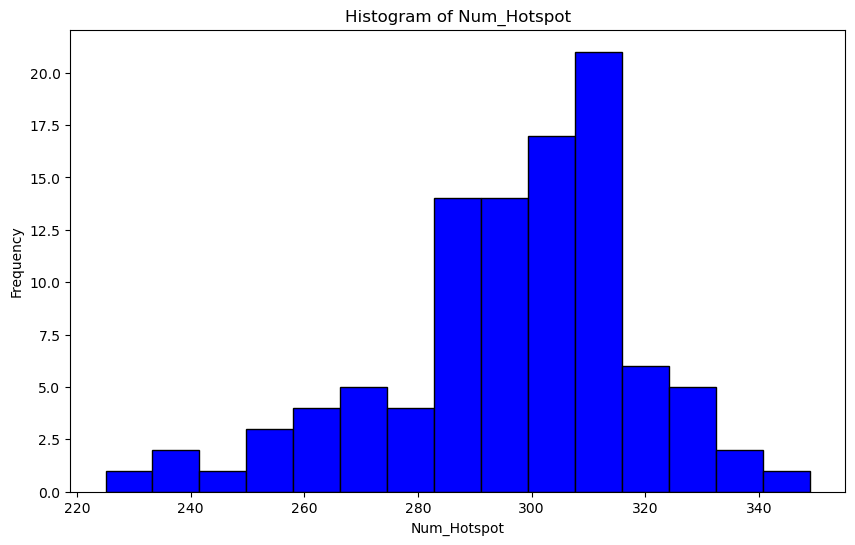

In [24]:
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.hist(data_grouped['Num_Hotspot'], bins=15, color='blue', edgecolor='black')  # Plot histogram
plt.title('Histogram of Num_Hotspot')  # Add a title
plt.xlabel('Num_Hotspot')  # Label for the X-axis
plt.ylabel('Frequency') 

In [25]:
data_grouped.sort_values("Num_Hotspot")

,county,Num_Hotspot
86,Swain,225
47,Hyde,236
45,Hertford,240
36,Gates,243
67,Orange,250
...,...,...
46,Hoke,329
76,Richmond,330
73,Pitt,335
25,Cumberland,336


Text(0, 0.5, 'Frequency')

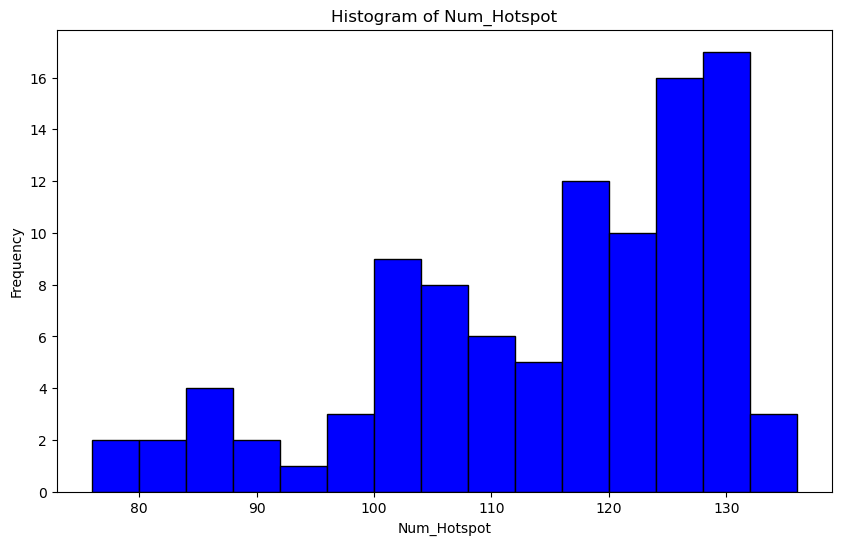

In [26]:
data_grouped_2 = data.groupby('county')['Hotspot_2'].sum().reset_index(name='Num_Hotspot')

plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.hist(data_grouped_2['Num_Hotspot'], bins=15, color='blue', edgecolor='black')  # Plot histogram
plt.title('Histogram of Num_Hotspot')  # Add a title
plt.xlabel('Num_Hotspot')  # Label for the X-axis
plt.ylabel('Frequency') 

In [27]:
columns_to_drop = ['pct_black', 'pct_natam', 'pct_asian', 'pct_hawaiian_islander',
                   'pct_other_race', 'pct_multirace', 'pop_hislat', 'pop_nonwhite']

# Drop the specified columns
data_full = data.drop(columns=columns_to_drop)

data_full.to_csv("data_full.csv")

In [35]:
# choosing categories for analysis

data_analysis = data[["county", "region", "date_count", "pop_dens", "Population", "cases",'weeklyper100k', "Hotspot_2"]]
data_analysis = data_analysis.loc[data_analysis['county'].isin(['Lincoln','Wake', 'Buncombe'])]
data_analysis


data_320 = data_analysis[["Population", "region", "pop_dens", "Hotspot_2"]]
#data_320 = pd.get_dummies(data_320, columns=['region'])

In [49]:
# data for stepwise
stepwise_data = pd.read_csv("resultdat.csv")

stepwise_data = stepwise_data.loc[stepwise_data['county'].isin(['Lincoln','Wake', 'Buncombe'])]


data_320 = stepwise_data[["Population", "region", "pop_dens", "hotspot_prop"]]
data_320 = data_320.copy()
mean_hotspot_prop = data_320['hotspot_prop'].mean()

# Create a new column 'above_mean' to check if 'hotspot_prop' is above the mean
data_320.loc[:, 'hotspot_prop_binary'] = data_320['hotspot_prop'] > mean_hotspot_prop
data_320 = pd.get_dummies(data_320, columns=['region'])
data_320 = data_320[["Population", "region_Central", "region_Eastern", "region_Western", "pop_dens", 'hotspot_prop_binary']]
data_320

,Population,region_Central,region_Eastern,region_Western,pop_dens,hotspot_prop_binary
10,271638,False,False,True,410.4,True
54,88742,True,False,False,293.4,True
91,1154170,False,True,False,1353.3,False


In [36]:
# from sklearn.preprocessing import OneHotEncoder


# # Applying One-Hot Encoding
# one_hot_encoder = OneHotEncoder(sparse=False)
# data_320 = one_hot_encoder.fit_transform(data_320[['region']])
# data_320 = pd.DataFrame(data_320, columns=one_hot_encoder.get_feature_names_out(['region']))


/Users/lizzithompson/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [50]:
data_analysis.to_csv("analysis_data_small.csv")
data_320.to_csv("data_320.csv")
#data.to_csv("data_large.csv")

In [34]:
data_320

,Population,pop_dens,Hotspot_2,region_Central,region_Eastern,region_Western
18110,271638.0,410.4,False,False,False,True
18210,271638.0,410.4,False,False,False,True
18310,271638.0,410.4,False,False,False,True
18410,271638.0,410.4,False,False,False,True
18510,271638.0,410.4,False,False,False,True
...,...,...,...,...,...,...
33191,1154170.0,1353.3,False,False,True,False
33291,1154170.0,1353.3,True,False,True,False
33391,1154170.0,1353.3,True,False,True,False
33491,1154170.0,1353.3,False,False,True,False
